# Homework 6-1: Testing the C code

## 1.	Make graphs to show how Csat  (equilibrium DIC) varies with T, S, AT, pCO2at .
*Use T=20oC, S=35.0 ‰, AT = 2350.0 µmol kg-1 and pCO2 = 280 ×10-6 atm as fixed reference values. 


In [16]:
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter
import numpy as np
import xarray as xr
import pandas as pd
import scipy
from datetime import datetime, timedelta
import time
import seaborn
import matplotlib.dates as mdates
import bottleneck as bn
import PyCO2SYS as pyco2
import gsw
import math
import netCDF4 as nc
import requests

# Import K's code for calculating the coefficients of the carb system
import calc_coeffs as co2
import H_poly as hpoly
from importlib import reload
import warnings
# warnings.filterwarnings('ignore')
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker

## a. Csat vs T for 0 < T < 35 (°C) 

In [17]:
import carbon as carbon

In [18]:
T = np.arange(0,35,0.1)
S = np.zeros(T.size)
S[:] = 35
TA = np.zeros(T.size)
TA[:] = 2350
pCO2 = np.zeros(T.size)
pCO2[:] = 280

Text(0.5, 0, 'T [°C]')

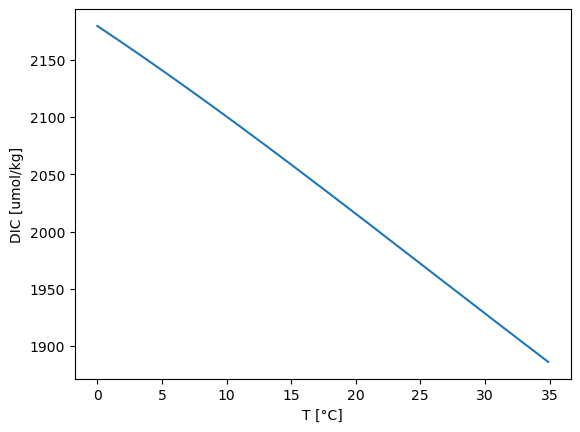

In [20]:
results = carbon.pHsolver(TA = TA, temperature = T, salinity = S, pCO2 = pCO2)
DIC = results['DIC']

fig, ax = plt.subplots()
ax.plot(T, DIC)
ax.set_ylabel('DIC [umol/kg]')
ax.set_xlabel('T [°C]')

## b. Csat vs S for 30 < S < 40 (‰)

In [21]:
S = np.arange(30,40,0.2)
T = np.zeros(S.size)
T[:] = 20
TA = np.zeros(S.size)
TA[:] = 2350
pCO2 = np.zeros(S.size)
pCO2[:] = 280


Text(0.5, 0, 'S [PSU]')

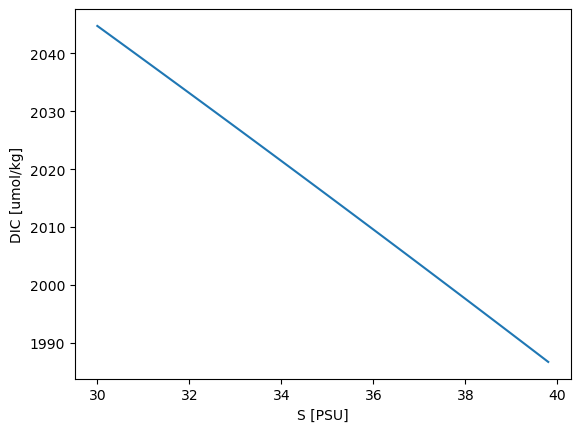

In [22]:
results = carbon.pHsolver(TA = TA, temperature = T, salinity = S, pCO2 = pCO2)
DIC = results['DIC']

fig, ax = plt.subplots()
ax.plot(S, DIC)
ax.set_ylabel('DIC [umol/kg]')
ax.set_xlabel('S [PSU]')

## c. Csat vs AT for 1800 < AT < 2800

Text(0.5, 0, 'TA [umol/kg]')

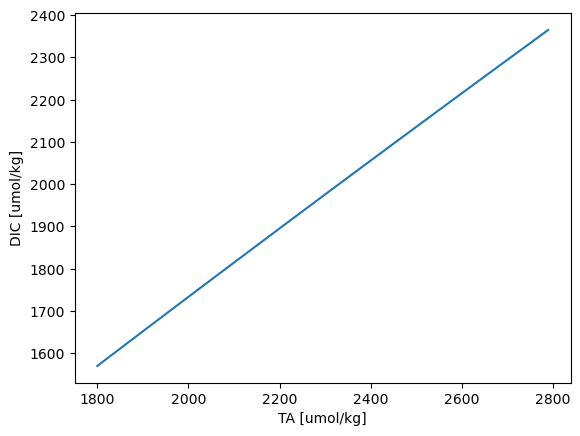

In [25]:
TA = np.arange(1800,2800,10)
T = np.zeros(TA.size)
T[:] = 20
S = np.zeros(TA.size)
S[:] = 35
pCO2 = np.zeros(TA.size)
pCO2[:] = 280

results = carbon.pHsolver(TA = TA, temperature = T, salinity = S, pCO2 = pCO2)
DIC = results['DIC']

fig, ax = plt.subplots()
ax.plot(TA, DIC)
ax.set_ylabel('DIC [umol/kg]')
ax.set_xlabel('TA [umol/kg]')

## d. Csat vs 10 ×10-6 < pCO2at < 2000 ×10-6 atm.

Text(0.5, 0, 'DIC [uatm]')

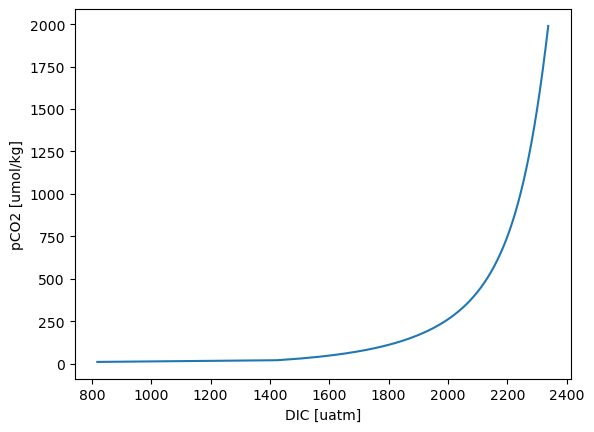

In [29]:
pCO2 = np.arange(10,2000,10)
T = np.zeros(pCO2.size)
T[:] = 20
S = np.zeros(pCO2.size)
S[:] = 35
TA = np.zeros(pCO2.size)
TA[:] = 2350

results = carbon.pHsolver(TA = TA, temperature = T, salinity = S, pCO2 = pCO2)
DIC = results['DIC']

fig, ax = plt.subplots()
ax.plot(DIC, pCO2)
ax.set_ylabel('pCO2 [umol/kg]')
ax.set_xlabel('DIC [uatm]')

# Discussion
## The Coding
I more or less combined the two assignments for this week into one. The major challenge was implementing some flexibility into my functions. I broke up the function a bit so that when called, the first thing it does it goes to a "main" function that determines what inputs were given. Based on the inputs, it then calls a second function that solves based on the input arguments. This is to say, a different function is called when TA and DIC are called than when TA and pCO2 are called. I had some trouble with keyword arguments, and again I had to work some magic with data types so the function would be flexible in how many values it accepted.

The function still lacks some degree of robustness cause I have not addressed cases when enough inputs are not provided (i.e. no error is thrown if only TA is given and not a second known).

I also checked the function against `PyCO2SYS` and got slightly different results, at least for pCO2. My best guess is that this is a result of either the iterative solution for H (when using DIC as an input) or calculating the coefficients. 

## C Cycling
1. DIC decreases linearly with increasing temperature
    * This makes sense since higher temperatures decrease solubility. Less solubility means pCO2 will be lost to the atmosphere and total DIC with decrease.
2. DIC increases linearly with increasing TA.
    * This makes sense since higher TA results in a higher buffering capacity, so more DIC can be stored in the water as a DIC species that is not lost to the atmosphere (i.e. not pCO2).
3. pCO2 increases exponentially with increasing DIC.
    * It makes sense that more DIC means more pCO2. The nonlinear nature is perhaps a result of pH and the introduction of H+ with pCO2.